In [264]:
from sympy import *
from safe_region_utils import *
from symbolic_utils import *
init_printing()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setting up example

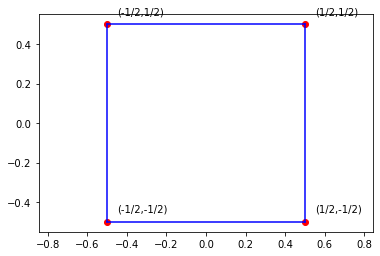

In [243]:
x, y = symbols("x y")
## Short Example ##
w = 0.5
square_points: list = [
    geometry.Point(val) for val in [[w, -w], [w, w], [-w, w], [-w, -w]]
]
square: geometry.Polygon = Polygon(*square_points)
plot_polygon(square)

w = Symbol("w", real=True, positive=True, nonzero=True)
square_points: list = [
    geometry.Point(val) for val in [[w, -w], [w, w], [-w, w], [-w, -w]]
]
square_param: geometry.Polygon = Polygon(*square_points)
compute_polygon_angles(square_param)
# traj_piecewise = Piecewise((sin(x / 2), x < 0), (x / 2, x >= 0))
# plot(traj_piecewise)
# plt.show()

In [245]:
a = Symbol("a", real=True, nonzero=True)
b = Symbol("b", real=True)
c = Symbol("c", real=True)

In [249]:
traj = a*x**2 + b*x +c
traj

In [247]:
traj = a*sin(b*x)
sinderiv = diff(traj, x)
sinderiv

In [248]:
solve(Eq(sinderiv, 0), x)

In [7]:
solve(Eq(diff(a*x**2, x), 0), x)

In [8]:
solve(Eq(diff(traj, x), 0), x)

In [9]:
traj

In [250]:
angles, vertex_pairs = compute_polygon_angles(square)
# find_transitions(-y + traj, angles, x, y, domain)  # fails bc Intersection type poorly handled
find_transitions(-y + traj, angles, x, y, Reals)  

solveset solution: EmptySet
solveset solution: {-b/(2*a)}
solution when finding transitions for angle pi: {-b/(2*a)}
solveset solution: EmptySet
solveset solution: {-b/(2*a)}
solution when finding transitions for angle 0: {-b/(2*a)}
pair used for transition point finding: {x: -b/(2*a)}
pair used for transition point finding: {x: -b/(2*a)}


In [ ]:
domain=Reals
traj = -y + a*x**2 + b*x +c

transitions: set = {}
# Compute slope symbolically
df_dy, df_dx = slope_sym(traj, x, y)
for angle in angles:
    # 2 vectors <x1, y1> <x2, y2>
    # parallel iff y1*x2 = x1*y2
    # use vectors <dfdx, dfdy> <cos(theta), sin(theta)>
    soln = solveset(Eq(df_dx * sin(angle), df_dy * cos(angle)), x, domain=domain)

    if soln == S.EmptySet:
        soln = solveset(
            Eq(df_dx * sin(angle), df_dy * cos(angle)), y, domain=domain
        )
        if soln != S.EmptySet and type(soln) != list:
            # In this case, type(soln): S.FiniteSet
            soln = [{y: soln_elem} for soln_elem in list(soln)]
    else:
        # Pack into list of dict so it's clear which variable has been solved for
        try:
            soln = [{x: soln_elem} for soln_elem in list(soln)]
        except:
            print(soln)

    for elem in soln:
        if angle in transitions:
            transitions[angle].append(elem)
        else:
            transitions[angle] = [elem]
# soln above may still be symbolic, so we have to evaluate the expression
# that's what happens below

transition_points = {}
set_of_transitions = set()
traj_eqn = Eq(traj, 0)
for angle, solns in transitions.items():
    for pair in solns:
        # pair should always be a dictionary
        assert type(pair) == dict, "Solution element was not a dictionary!"
        # pair looks like {x: f(y)} or {y: f(x)}
        # remove one variable from equation by substituting pair into traj_eqn
        traj_eqn_single_var = traj_eqn.subs(pair)

        # before going further, figure out the variable for
        # which pair contains a solution
        soln_var = [k for k in pair][0]  # variable is the dict key
        other_var = y if soln_var == x else x

        # traj_eqn used to have two variables but now has only one
        single_var_solns = solve(traj_eqn_single_var, other_var)

        for single_var_soln in single_var_solns:
            # substitute in single_var_soln to solve for soln_var
            solved_eqn = Eq(soln_var, pair[soln_var]).subs(
                other_var, single_var_soln
            )
            # with this, we have a solution for the transition point
            if soln_var == x:
                print("x-coord:", solved_eqn.rhs)
                print("y-coord:", single_var_soln)
                transition_point = Point(solved_eqn.rhs, single_var_soln)
            elif soln_var == y:
                transition_point = Point(single_var_soln, solved_eqn.rhs)
            set_of_transitions.add(transition_point)
            if angle in transition_points:
                transition_points[angle].append(transition_point)
            else:
                transition_points[angle] = [transition_point]


In [48]:
single_var_solns

NameError: name 'single_var_solns' is not defined

In [49]:
pair

NameError: name 'pair' is not defined

In [50]:
traj_eqn_single_var

NameError: name 'traj_eqn_single_var' is not defined

In [51]:
solve(traj_eqn, y)

NameError: name 'traj_eqn' is not defined

In [52]:
len(cond.free_symbols)

NameError: name 'cond' is not defined

In [251]:
domain = Interval(-12, 9)
xbounds = [-15, 12]
ybounds = [-3, 6]
example_name = "symbolic parabola"

traj = a*x**2 + b*x +c

cond = compute_unsafe_cond_symbolic(
    x,
    y,
    square,
    traj,
    Reals,
    add_notches=True,
)
cond

solveset solution: EmptySet
solveset solution: {-b/(2*a)}
solution when finding transitions for angle pi: {-b/(2*a)}
solveset solution: EmptySet
solveset solution: {-b/(2*a)}
solution when finding transitions for angle 0: {-b/(2*a)}
pair used for transition point finding: {x: -b/(2*a)}
pair used for transition point finding: {x: -b/(2*a)}
func_var: x
transitions as set: {Point2D(oo, oo*a + oo*b + c), Point2D(-oo, oo*a - oo*b + c), Point2D(-b/(2*a), c - b**2/(4*a))}
transitions: [Point2D(-oo, oo*a - oo*b + c), Point2D(-b/(2*a), c - b**2/(4*a)), Point2D(oo, oo*a + oo*b + c)]
func_var_transitions: [-oo, -b/(2*a), oo]
var intervals: [(-oo, -b/(2*a)), (-b/(2*a), oo)]


                                                                                                        
⎛                ⎛    ⎛⎧                 2                               ⎞    ⎞ ⎛    ⎛⎧                 
⎜                ⎜    ⎜⎪                b                         1    b ⎟    ⎟ ⎜    ⎜⎪                b
⎜      1    b    ⎜    ⎜⎪           c - ───              for x < - ─ - ───⎟   1⎟ ⎜    ⎜⎪           c - ──
⎜x ≥ - ─ - ─── ∧ ⎜y - ⎜⎨               4⋅a                        2   2⋅a⎟ - ─⎟⋅⎜y - ⎜⎨               4⋅
⎜      2   2⋅a   ⎜    ⎜⎪                                                 ⎟   2⎟ ⎜    ⎜⎪                 
⎜                ⎜    ⎜⎪           2                                     ⎟    ⎟ ⎜    ⎜⎪           2     
⎝                ⎝    ⎝⎩a⋅(x + 1/2)  + b⋅(x + 1/2) + c      for x ≤ ∞    ⎠    ⎠ ⎝    ⎝⎩a⋅(x - 1/2)  + b⋅
                                                                                                        

                                                      

In [252]:
cond = compute_unsafe_cond_symbolic(
    x,
    y,
    square_param,
    traj,
    Reals,
    add_notches=True,
)
cond

solveset solution: EmptySet
solveset solution: {-b/(2*a)}
solution when finding transitions for angle pi: {-b/(2*a)}
solveset solution: EmptySet
solveset solution: {-b/(2*a)}
solution when finding transitions for angle 0: {-b/(2*a)}
pair used for transition point finding: {x: -b/(2*a)}
pair used for transition point finding: {x: -b/(2*a)}
func_var: x
transitions as set: {Point2D(oo, oo*a + oo*b + c), Point2D(-oo, oo*a - oo*b + c), Point2D(-b/(2*a), c - b**2/(4*a))}
transitions: [Point2D(-oo, oo*a - oo*b + c), Point2D(-b/(2*a), c - b**2/(4*a)), Point2D(oo, oo*a + oo*b + c)]
func_var_transitions: [-oo, -b/(2*a), oo]
var intervals: [(-oo, -b/(2*a)), (-b/(2*a), oo)]


                                                                                                        
⎛               ⎛         ⎛⎧                2                            ⎞⎞ ⎛        ⎛⎧               2 
⎜               ⎜         ⎜⎪               b                           b ⎟⎟ ⎜        ⎜⎪              b  
⎜          b    ⎜         ⎜⎪          c - ───             for w - x > ───⎟⎟ ⎜        ⎜⎪         c - ─── 
⎜x ≥ -w - ─── ∧ ⎜-w + y - ⎜⎨              4⋅a                         2⋅a⎟⎟⋅⎜w + y - ⎜⎨             4⋅a 
⎜         2⋅a   ⎜         ⎜⎪                                             ⎟⎟ ⎜        ⎜⎪                 
⎜               ⎜         ⎜⎪          2                                  ⎟⎟ ⎜        ⎜⎪         2       
⎝               ⎝         ⎝⎩a⋅(-w + x)  + b⋅(-w + x) + c  for w - x ≥ -∞ ⎠⎠ ⎝        ⎝⎩a⋅(w + x)  + b⋅(w
                                                                                                        

                                                      

In [253]:
plot_condition(x, y, cond, xbounds, ybounds, title=example_name)

Can't plot `cond` since it has too many variables. Please use .subs() to plot an instantation of this condition.
Extraneous variables to substitute out are {'w', 'b', 'c', 'a'}.


In [254]:
plot_condition(x, y, cond.subs(a, 1/4).subs(b, 1).subs(c, 2), xbounds, ybounds, title=example_name)

Can't plot `cond` since it has too many variables. Please use .subs() to plot an instantation of this condition.
Extraneous variables to substitute out are {'w'}.


In [255]:
plot_condition(x, y, cond.subs(a, 1/4).subs(b, 1).subs(c, 2), [-5,0], [0,2], title=example_name, resolution=0.05)

Can't plot `cond` since it has too many variables. Please use .subs() to plot an instantation of this condition.
Extraneous variables to substitute out are {'w'}.


In [ ]:
cond.subs(a, 1/4).subs(b, 1).subs(c, 2)

In [ ]:
print(
    "\nPlotting dot grid visualization of safe and unsafe regions.", 
    "This may take up to 20 seconds to plot.\nOnce displayed, close plot to continue example...\n"
)

plot_condition(x, y, cond.subs(a, 1/4), xbounds, ybounds, title=example_name)
mathematica_output = print_mathematica(
    x, y, cond, xbounds, ybounds, traj_piecewise, square
)
print("Mathematica command for plotting:\n", mathematica_output)

In [ ]:
traj

In [ ]:
cond.subs(a, 1)

In [ ]:
square.vertices

## Periodic

In [10]:
a

In [11]:
solve(Eq(diff(a*sin(x), x), 0), x)

In [12]:
b.assumptions0

{'real': True,
 'infinite': False,
 'finite': True,
 'complex': True,
 'imaginary': False,
 'commutative': True,
 'extended_real': True,
 'hermitian': True}

In [61]:
a = Symbol('a', real=True, nonzero=True)
b = Symbol('b', real=True, nonzero=True)
c = Symbol("c", real=True)

In [62]:
_n = Symbol("n")
soln = Union(ImageSet(Lambda(_n, (2*_n*pi + pi/2)/b), Integers), ImageSet(Lambda(_n, (2*_n*pi - pi/2)/b), Integers))
soln

⎧        π │      ⎫   ⎧        π │      ⎫
⎪2⋅π⋅n - ─ │      ⎪   ⎪2⋅π⋅n + ─ │      ⎪
⎨        2 │      ⎬   ⎨        2 │      ⎬
⎪───────── │ n ∊ ℤ⎪ ∪ ⎪───────── │ n ∊ ℤ⎪
⎩    b     │      ⎭   ⎩    b     │      ⎭

In [63]:
type(soln) is FiniteSet

False

In [64]:
type(soln)

sympy.sets.sets.Union

In [65]:
traj = sin(x)

angles, vertex_pairs = compute_polygon_angles(square)
# find_transitions(-y + traj, angles, x, y, domain)  # fails bc Intersection type poorly handled
find_transitions(-y + traj, angles, x, y, domain)

{-7*pi/2, -5*pi/2, -3*pi/2, -pi/2, pi/2, 3*pi/2, 5*pi/2}
{-7*pi/2, -5*pi/2, -3*pi/2, -pi/2, pi/2, 3*pi/2, 5*pi/2}


In [66]:
# a = Symbol('a', real=True, nonzero=True)
b = Symbol('b', real=True, nonzero=True)
a = Symbol('a', real=True)
# b = Symbol('b', real=True)
c = Symbol("c", real=True)

In [71]:
traj = a*sin(b*x)

angles, vertex_pairs = compute_polygon_angles(square)
# find_transitions(-y + traj, angles, x, y, domain)  # fails bc Intersection type poorly handled
find_transitions(-y + traj, angles, x, y, Reals)

Union(ImageSet(Lambda(_n, (2*_n*pi + pi/2)/b), Integers), ImageSet(Lambda(_n, (2*_n*pi - pi/2)/b), Integers))
Union(ImageSet(Lambda(_n, (2*_n*pi + pi/2)/b), Integers), ImageSet(Lambda(_n, (2*_n*pi - pi/2)/b), Integers))


AttributeError: 'Union' object has no attribute 'as_base_exp'

In [45]:
ConditionSet(x, Ne(b, 0), Union(ImageSet(Lambda(x, (2*pi*x - pi/2)/b), Complement(Integers, ConditionSet(_n, Eq(b, 0)))), ImageSet(Lambda(x, (2*pi*x + pi/2)/b), Complement(Integers, ConditionSet(_n, Eq(b, 0))))))

⎧        π │      ⎫   ⎧        π │      ⎫
⎪2⋅π⋅x - ─ │      ⎪   ⎪2⋅π⋅x + ─ │      ⎪
⎨        2 │      ⎬   ⎨        2 │      ⎬
⎪───────── │ x ∊ ℤ⎪ ∪ ⎪───────── │ x ∊ ℤ⎪
⎩    b     │      ⎭   ⎩    b     │      ⎭

In [37]:
Union(ImageSet(Lambda(_n, (2*_n*pi + pi/2)/b), Integers), ImageSet(Lambda(_n, (2*_n*pi - pi/2)/b), Integers))

⎧        π │      ⎫   ⎧        π │      ⎫
⎪2⋅π⋅n - ─ │      ⎪   ⎪2⋅π⋅n + ─ │      ⎪
⎨        2 │      ⎬   ⎨        2 │      ⎬
⎪───────── │ n ∊ ℤ⎪ ∪ ⎪───────── │ n ∊ ℤ⎪
⎩    b     │      ⎭   ⎩    b     │      ⎭

In [77]:
# TODO: split Unions
ImageSet(Lambda(_n, (2*_n*pi + pi/2)/b), Integers)

⎧        π │      ⎫
⎪2⋅π⋅n + ─ │      ⎪
⎨        2 │      ⎬
⎪───────── │ n ∊ ℤ⎪
⎩    b     │      ⎭

In [81]:
ImageSet(Lambda(_n, (2*_n*pi + pi/2)/b), Integers).args[0]

In [108]:
domain

In [109]:
find_transitions(-y + traj, angles, x, y, domain)  # fails bc Intersection type poorly handled

TypeError: cannot determine truth value of Relational

In [107]:
solveres = solveset(Eq(diff(a*sin(b*x), x), 0), x, domain)

TypeError: cannot determine truth value of Relational

In [85]:
solveres = solveset(Eq(diff(a*sin(b*x), x), 0), x, Reals)
solveres

⎧        π │      ⎫   ⎧        π │      ⎫
⎪2⋅n⋅π + ─ │      ⎪   ⎪2⋅n⋅π - ─ │      ⎪
⎨        2 │      ⎬   ⎨        2 │      ⎬
⎪───────── │ n ∊ ℤ⎪ ∪ ⎪───────── │ n ∊ ℤ⎪
⎩    b     │      ⎭   ⎩    b     │      ⎭

In [113]:
# potentially useful and clean way of real-ify-ing this at the end
solveres.subs(b, 2).intersect(domain)

In [87]:
solveres.args

⎛⎧        π │      ⎫  ⎧        π │      ⎫⎞
⎜⎪2⋅n⋅π + ─ │      ⎪  ⎪2⋅n⋅π - ─ │      ⎪⎟
⎜⎨        2 │      ⎬  ⎨        2 │      ⎬⎟
⎜⎪───────── │ n ∊ ℤ⎪, ⎪───────── │ n ∊ ℤ⎪⎟
⎝⎩    b     │      ⎭  ⎩    b     │      ⎭⎠

In [106]:
print(type(solveres.args[0].args[0]))
solveres.args[0].args

<class 'sympy.core.function.Lambda'>


In [104]:
# split union
# then extract the lambda 
solveres.args[0].args[0].args

In [105]:
# then split the lambda into lhs and rhs
solveres.args[0].args[0].args[1]

## Piecewise

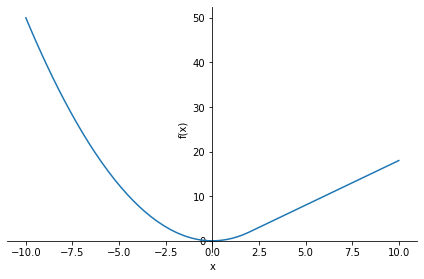

⎧           2                    
⎪        c⋅x            for b > x
⎨                                
⎪ 2                              
⎩b ⋅c + 2⋅b⋅c⋅(-b + x)  otherwise

In [380]:
c = Symbol("c", real=True, nonzero=True) # curvature
b = Symbol('b', real=True, positive=True) # boundary
# b = Symbol('b', real=True) # boundary

traj_piecewise = Piecewise(
                    (c*x**2, x < b),
                    (2*b*c*(x-b) + b**2*c, x >= b),
                )
plot(traj_piecewise.subs(c, 0.5).subs(b, 2))
traj_piecewise

In [257]:
# NOTE: for b strictly positive, it's a lucky coincidence 
# TODO: how to specify b > 1 somehow as an assumption? 

In [258]:
solveset(Eq(0, -2*c*x), x, Reals)

In [259]:
# TODO: why doesn't this work?
solveset(Eq(diff(traj_piecewise, x),0), x, Reals)

NotImplementedError: 
multivariate conditions are not handled.

In [219]:
transition_x = 0
for piece in traj_piecewise.args:
    func, cond = piece
    if cond.subs(x, transition_x):
        print(func)
        break

c*x**2


In [205]:
traj_piecewise.args

⎛⎛   2       ⎞  ⎛ 2                         ⎞⎞
⎝⎝c⋅x , b > x⎠, ⎝b ⋅c + 2⋅b⋅c⋅(-b + x), True⎠⎠

In [208]:
(b > x).subs(x, 0)

True

In [207]:
b > 0

True

In [212]:
transition_x = 0
for piece in traj_piecewise.args:
    func, cond = piece
    soln = solve(Eq(diff(func, x), 0), x)
    if soln:
        print(soln)
        if cond.subs(x, soln[0]):
            print(func)

[0]
c*x**2


In [229]:
piecewise_intervals = [Interval(-oo, b), Interval(b, oo)]
piecewise_intervals

In [162]:
list(zip(traj_piecewise.args, piecewise_intervals))

⎡⎛⎛   2       ⎞         ⎞  ⎛⎛ 2                         ⎞        ⎞⎤
⎣⎝⎝c⋅x , b > x⎠, (-∞, b]⎠, ⎝⎝b ⋅c + 2⋅b⋅c⋅(-b + x), True⎠, [b, ∞)⎠⎦

In [290]:
(-oo).is_imaginary

False

In [294]:
(oo*c).is_imaginary

False

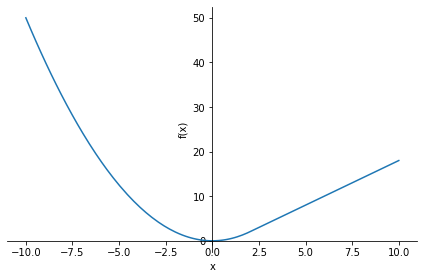

In [412]:
plot(traj_piecewise.subs(c, 0.5).subs(b, 2))

In [421]:
domain = Interval(-12, 9)
xbounds = [-10, 10]
ybounds = [-4, 10]
example_name = "symbolic ACAS X"


cond = compute_unsafe_cond_symbolic(
    x,
    y,
    square,
    traj_piecewise,
    Reals,
    add_notches=True,
    intervals = piecewise_intervals # NOTE: new 
)
cond

                                                                                                        
⎛              ⎛    ⎛⎧            2                               ⎞    ⎞ ⎛    ⎛⎧            2           
⎜              ⎜    ⎜⎪           b ⋅c              for b > x - 1/2⎟   1⎟ ⎜    ⎜⎪           b ⋅c         
⎜x ≥ b - 1/2 ∧ ⎜y - ⎜⎨                                            ⎟ - ─⎟⋅⎜y - ⎜⎨                        
⎜              ⎜    ⎜⎪ 2                                          ⎟   2⎟ ⎜    ⎜⎪ 2                      
⎝              ⎝    ⎝⎩b ⋅c + 2⋅b⋅c⋅(-b + x - 1/2)     for x ≤ ∞   ⎠    ⎠ ⎝    ⎝⎩b ⋅c + 2⋅b⋅c⋅(-b + x + 1
                                                                                                        

                                                                                                        
                    ⎞    ⎞    ⎞   ⎛              ⎛    ⎛⎧            2                               ⎞   
     for b > x + 1/2⎟   1⎟    ⎟   ⎜              ⎜    

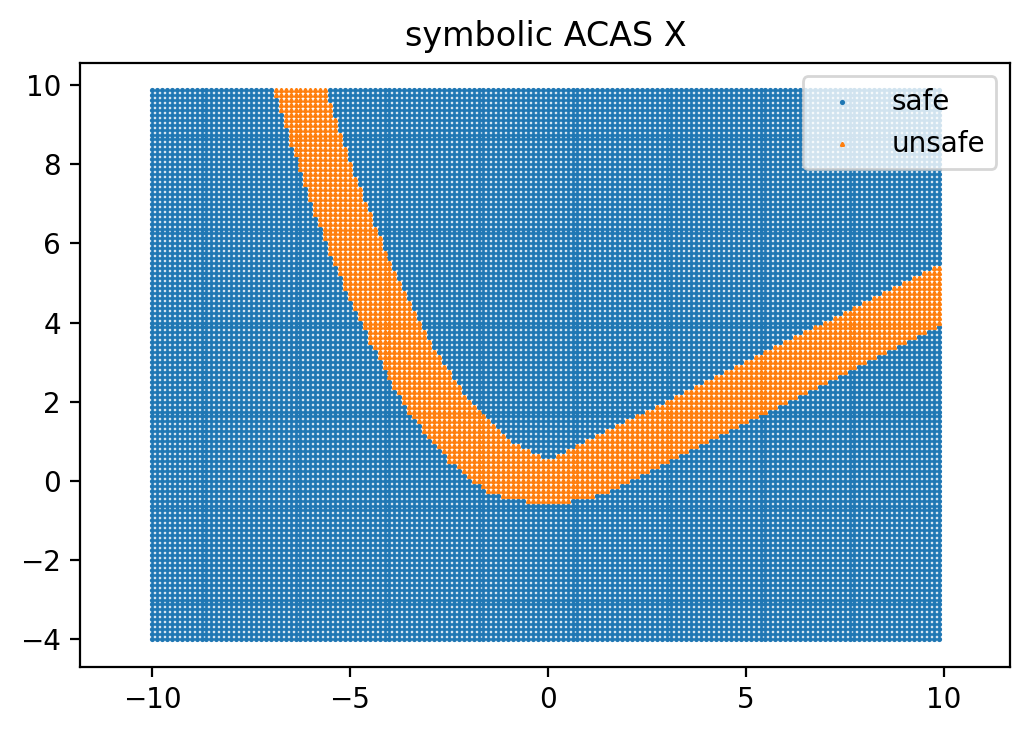

In [424]:
plot_condition(x, y, cond.subs(c, 0.25).subs(b, 1), xbounds, ybounds, title=example_name, resolution = 0.125)

In [425]:
resolution=0.25
title = example_name

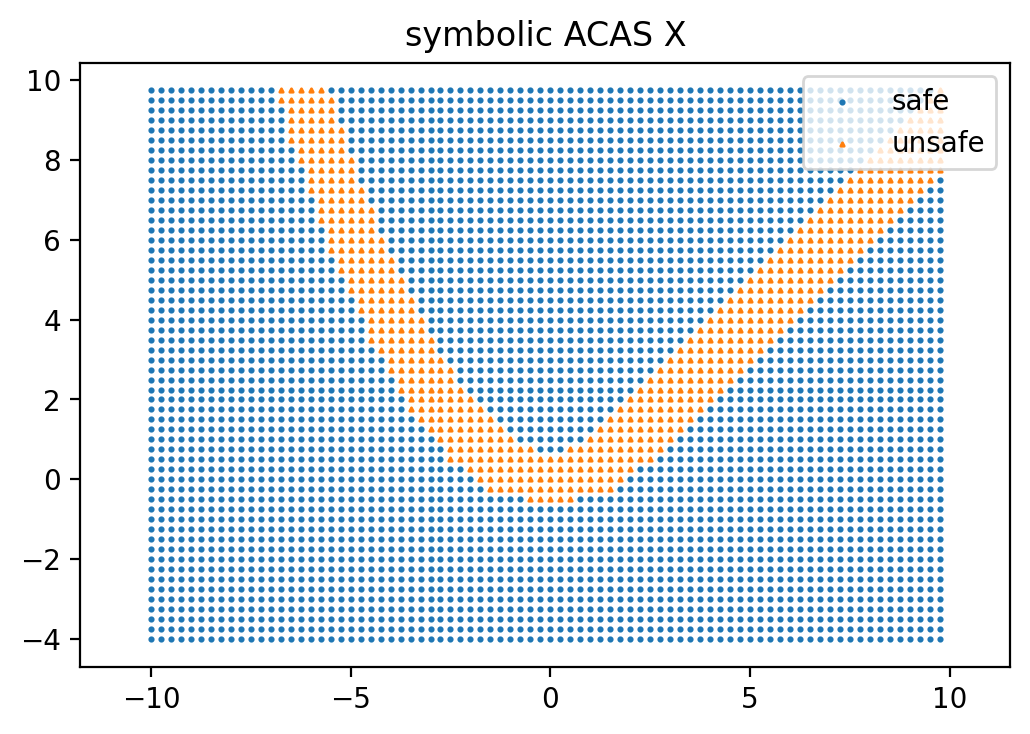

In [427]:
condsub = cond.subs(c, 0.25).subs(b, 2)

fig = plt.figure()
fig.set_dpi(200)
ax = fig.gca()

# nelem = (xbounds[1] - xbounds[0]) * (ybounds[1] - ybounds[0]) / (resolution ** 2)
# count = 0
SAFE_COLOR = "#1f77b4"
UNSAFE_COLOR = "#ff7f0e"
if resolution < 0.5:
    dotscale = 6
elif resolution < 1:
    dotscale = 4
else:
    dotscale = 3

xpoints_safe = []
xpoints_unsafe = []
ypoints_safe = []
ypoints_unsafe = []
for x0 in np.arange(xbounds[0], xbounds[1], resolution):
    for y0 in np.arange(ybounds[0], ybounds[1], resolution):
        # count += 1
        # TODO: use is_safe
        is_safe = (~condsub).subs([(x, x0), (y, y0)])
        if is_safe:
            xpoints_safe.append(x0)
            ypoints_safe.append(y0)
        else:
            xpoints_unsafe.append(x0)
            ypoints_unsafe.append(y0)
ax.scatter(xpoints_safe, ypoints_safe, s=resolution * dotscale, c=SAFE_COLOR)
ax.scatter(
    xpoints_unsafe,
    ypoints_unsafe,
    s=resolution * dotscale,
    c=UNSAFE_COLOR,
    marker="^",
)
ax.legend(["safe", "unsafe"])
ax.axis("equal")

ax.set_title(title)
plt.show()

In [ ]:
x0

In [ ]:
y0

In [ ]:
cond

In [ ]:
condsub.subs(x, x0)

In [ ]:
condsub.subs(y, y0)

In [ ]:
condsub.subs(x, x0).subs(y, y0)

In [ ]:
plot_condition(x, y, cond.subs(c, 0.5).subs(b, 2), xbounds, ybounds, title=example_name)

In [181]:
traj_piecewise.args[0][1] # [interval [c, oo]]

In [179]:
traj_piecewise.args[1][1]

True

In [126]:
traj_piecewise.args

list[(c*x**2, b > x), (b**2*c + 2*b*c*(-b + x), True)]

In [338]:
poly = square
trajectory = traj_piecewise
domain = Reals
intervals = piecewise_intervals # NOTE: new 

In [352]:
angles, vertex_pairs = compute_polygon_angles(poly)
verts = poly.vertices
if y not in trajectory.free_symbols:
    func_var = x
    keyfunc = lambda p: p.x
elif x not in trajectory.free_symbols:
    func_var = y
    keyfunc = lambda p: p.y
else:
    raise Exception("Trajectory had two variables!")

# compute width to use in g() function later
# for functions f(y), this is actually height
w_point = max(
    [
        -1 * min([v - poly.centroid for v in verts], key=keyfunc),
        max([v - poly.centroid for v in verts], key=keyfunc),
    ],
    key=keyfunc,
)
w = getattr(w_point, str(func_var))

# construct a large set of transitions
# set_of_transitions = TransitionPointSet()
set_of_transitions = set()
unique_transition_points = set()
lookup_dict = {}
if type(trajectory) == Piecewise:
    # For piecewise trajectories, we need to find transitions for each piece
    # for (subtraj, subcond) in trajectory.as_expr_set_pairs():
    # as_expr_set_pairs doesn't work for multivariate (symbolic) trajectories
    for i, (subtraj, subcond) in enumerate(trajectory.args):
        # trim domain by computing intersection, so we don't find transitions
        # outside of the domain for each piece of the trajectory
        # TODO fix hardcoding
        # subdomain = subcond.intersect(domain)  # invalid for symbolic
        subdomain = Reals  # for symbolic just leave as Reals??
        # print(f"\nPiecewise: {subtraj} for condition {subcond}")

        if y not in subtraj.free_symbols:  # form y=f(x)
            # TODO: domain? for finding outside of piecewise range
            subset_of_transitions = find_transitions_symbolic(
                -y + subtraj, angles, x, y, domain=domain
            )
            # add piecewise boundary
            if (
                intervals[i].inf.is_imaginary
                or subtraj.subs(func_var, intervals[i].inf).is_imaginary
            ):
                print(
                    "imaginary!",
                    intervals[i].inf,
                    subtraj.subs(func_var, intervals[i].inf),
                )
                left_bound = None
            else:
                left_bound = Point(
                    intervals[i].inf, subtraj.subs(func_var, intervals[i].inf)
                )
            if (
                intervals[i].sup.is_imaginary
                or subtraj.subs(func_var, intervals[i].sup).is_imaginary
            ):
                print(
                    "imaginary!",
                    intervals[i].sup,
                    subtraj.subs(func_var, intervals[i].sup),
                )
                right_bound = None
            else:
                right_bound = Point(
                    intervals[i].sup, subtraj.subs(func_var, intervals[i].sup)
                )
        elif x not in subtraj.free_symbols:  # form x=f(y)
            # TODO: domain? for finding outside of piecewise range
            subset_of_transitions = find_transitions_symbolic(
                -x + subtraj, angles, x, y, domain=domain
            )
            # add piecewise boundary
            if (
                subtraj.subs(func_var, intervals[i].inf).is_imaginary
                or intervals[i].inf.is_imaginary
            ):
                left_bound = None
            else:
                left_bound = Point(
                    subtraj.subs(func_var, intervals[i].inf), intervals[i].inf
                )
            if (
                subtraj.subs(func_var, intervals[i].sup).is_imaginary
                or intervals[i].sup.is_imaginary
            ):
                right_bound = None
            else:
                right_bound = Point(
                    subtraj.subs(func_var, intervals[i].sup), intervals[i].sup
                )
        # set_of_transitions.update(subset_of_transitions)
        for elem in subset_of_transitions:
            if elem.point not in unique_transition_points:
                set_of_transitions.add(elem)
                unique_transition_points.add(elem.point)
            point_var = getattr(elem.point, str(func_var))
            if point_var in lookup_dict:
                lookup_dict[point_var].append(subtraj)
            else:
                lookup_dict[point_var] = [subtraj]

        # if left_bound.x.is_finite and left_bound.y.is_finite:
        #     set_of_transitions.add(left_bound)
        # if right_bound.x.is_finite and right_bound.y.is_finite:
        #     set_of_transitions.add(right_bound)
        if left_bound:
            if left_bound not in unique_transition_points:
                set_of_transitions.add(TransitionPoint(left_bound, None, subtraj))
                unique_transition_points.add(left_bound)
            point_var = getattr(left_bound, str(func_var))
            if point_var in lookup_dict:
                lookup_dict[point_var].append(subtraj)
            else:
                lookup_dict[point_var] = [subtraj]


        if right_bound:
            if right_bound not in unique_transition_points:
                set_of_transitions.add(TransitionPoint(right_bound, None, subtraj))
                unique_transition_points.add(right_bound)
            point_var = getattr(right_bound, str(func_var))
            if point_var in lookup_dict:
                lookup_dict[point_var].append(subtraj)
            else:
                lookup_dict[point_var] = [subtraj]

else:
    if y not in trajectory.free_symbols:
        subset_of_transitions = find_transitions_symbolic(
            -y + trajectory, angles, x, y, domain=domain
        )
        # Add left and right boundaries to check for notch there too
        left_bound = Point(domain.inf, trajectory.subs(func_var, domain.inf))
        right_bound = Point(domain.sup, trajectory.subs(func_var, domain.sup))
    elif x not in trajectory.free_symbols:
        subset_of_transitions = find_transitions_symbolic(
            -x + trajectory, angles, x, y, domain=domain
        )
        # Add left and right boundaries to check for notch there too
        left_bound = Point(trajectory.subs(func_var, domain.inf), domain.inf)
        right_bound = Point(trajectory.subs(func_var, domain.sup), domain.sup)

    # set_of_transitions.update(subset_of_transitions)
    for elem in subset_of_transitions:
        if elem.point not in unique_transition_points:
            set_of_transitions.add(elem)
            unique_transition_points.add(elem.point)
        point_var = getattr(elem.point, str(func_var))
        if point_var in lookup_dict:
            lookup_dict[point_var].append(subtraj)
        else:
            lookup_dict[point_var] = [subtraj]

    # if left_bound.x.is_finite and left_bound.y.is_finite:
    #     set_of_transitions.add(left_bound)
    # if right_bound.x.is_finite and right_bound.y.is_finite:
    #     set_of_transitions.add(right_bound)
    if left_bound:
        if left_bound not in unique_transition_points:
            set_of_transitions.add(TransitionPoint(left_bound, None, subtraj))
            unique_transition_points.add(left_bound)
        point_var = getattr(left_bound, str(func_var))
        if point_var in lookup_dict:
            lookup_dict[point_var].append(subtraj)
        else:
            lookup_dict[point_var] = [subtraj]

    if right_bound:
        if right_bound not in unique_transition_points:
            set_of_transitions.add(TransitionPoint(right_bound, None, subtraj))
            unique_transition_points.add(right_bound)
        point_var = getattr(right_bound, str(func_var))
        if point_var in lookup_dict:
            lookup_dict[point_var].append(subtraj)
        else:
            lookup_dict[point_var] = [subtraj]

    # set_of_transitions.add(TransitionPoint(left_bound, None, subtraj))
    # set_of_transitions.add(TransitionPoint(right_bound, None, subtraj))

# In order to identify which corners are active over which intervals,
# sort transitions and identify active corners at the midpoints of the intervals
# defined by transition points.
# TODO: make sure this works or handle another way? - not guaranteed to work!
# print(f"func_var: {func_var}")
print(f"transitions as set: {set_of_transitions}")
sorted_transitions: list = sorted(
    set_of_transitions,
    key=lambda tp: getattr(tp.point, str(func_var)),
)

transitions as set: {BoundaryPoint2D(0, 0) for function Eq(c*x**2 - y, 0), BoundaryPoint2D(b, b**2*c) for function c*x**2, BoundaryPoint2D(-oo, oo*c) for function c*x**2, BoundaryPoint2D(oo, b**2*c + oo*c) for function b**2*c + 2*b*c*(-b + x)}


In [353]:
lookup_dict

In [372]:
func_var_transitions = [
    getattr(tp.point, str(func_var)) for tp in sorted_transitions
]
print(f"func_var_transitions: {func_var_transitions}")

# # Map each midpoint angle to the active corner. Because we're only supporting
# # symmetric polygons so far, we only need to find a single active corner here,
# # and we can use its opposing corner (due to central symmetry) later.
# active_corners: dict = {}
# for midpoint_angle in midpoint_angles:
#     for k, v in corners_to_angles.items():
#         print(midpoint_angle)
#         print(v)
#         # NOTE: fails for symbolic trajectory parameters
#         if midpoint_angle % (2 * pi) in v:
#             active_corners[midpoint_angle] = k
var_intervals = list(
    zip(func_var_transitions[:-1], func_var_transitions[1:])
)  # same len as midpoints
assert var_intervals, f"var_intervals: {var_intervals}. Evaluated to False."

print(f"var intervals: {var_intervals}")

# Construct the full boolean formulation of the *unsafe* region
total_cond = None
for i, var_interval in enumerate(var_intervals):
    if func_var == x:
        x_left = var_interval[0]
        y_left = trajectory.subs(x, x_left)
        x_right = var_interval[1]
        y_right = trajectory.subs(x, x_right)
    elif func_var == y:
        y_left = var_interval[0]
        x_left = trajectory.subs(y, y_left)
        y_right = var_interval[1]
        x_right = trajectory.subs(y, y_right)

    poly_center_left = Point(x_left, y_left)
    poly_center_right = Point(x_right, y_right)

    # # Assume symmetric polygon.
    # active_corner_offset = active_corners[midpoint_angles[i]]
    # line_left = Line(poly_center_left, poly_center_left + active_corner_offset)
    # line_right = Line(poly_center_right, poly_center_right + active_corner_offset)
    # # using Line.equation() creates duplicate x,y variables and ruins .subs() call later
    # # Ensure this check only applies between the active corners at the start and end of the interval
    # left_a, left_b, left_c = line_left.coefficients
    # right_a, right_b, right_c = line_right.coefficients
    # left_eq = left_a * x + left_b * y + left_c
    # right_eq = right_a * x + right_b * y + right_c
    # corner_cond = left_eq * right_eq <= 0

    # Ensure this check only applies between the transition points (plus/minus width)
    # Discard nonsense > -inf or < +inf
    if func_var == x:
        if x_left is -oo:
            func_var_cond = x <= (x_right + w)
        elif x_right is oo:
            func_var_cond = x >= (x_left - w)
        else:
            func_var_cond = (x >= (x_left - w)) & (x <= (x_right + w))
    elif func_var == y:
        # note that w is actually height when found above
        if y_left is -oo:
            func_var_cond = y <= (y_right + w)
        elif y_right is oo:
            func_var_cond = y >= (y_left - w)
        else:
            func_var_cond = (y >= (y_left - w)) & (y <= (y_right + w))

    # construct g functions
    # same trajectory over this interval, held constant outside of it
    if type(trajectory) == Piecewise:
        if func_var == x:
            # Use an open interval in case two cases hold exactly at x_left
            # TODO: make sure this works symbolically
            # TODO: write code to map interval or transition point to function
            left_funcs = set(lookup_dict[x_left])
            right_funcs = set(lookup_dict[x_right])
            common_funcs = left_funcs.intersection(right_funcs)
            assert len(common_funcs) == 1, "Ambiguous which function to use here!"
            current_fn = common_funcs.pop()
            # Discard nonsense infinities
            # TODO(nishant): pull this logic out into a different function
            if x_left is -oo:
                g = y - Piecewise(
                    (current_fn, x <= x_right),
                    (y_right, x > x_right),
                )
            elif x_right is oo:
                g = y - Piecewise(
                    (y_left, x < x_left),
                    (current_fn, x <= x_right),
                )
            else:
                g = y - Piecewise(
                    (y_left, x < x_left),
                    (current_fn, x <= x_right),
                    (y_right, x > x_right),
                )
        elif func_var == y:
            # Use an open interval in case two cases hold exactly at y_left
            current_piece = trajectory.as_expr_set_pairs(
                Interval.open(y_left, y_right)
            )
            if len(current_piece) > 1:
                print(
                    f"Warning! more than one piecewise segment detected \
                    over interval ({y_left}, {y_right}). Results may be \
                    erroneous due to mis-specified piecewise functions."
                )
            current_fn = current_piece[0][0]
            if y_left is -oo:
                g = x - Piecewise(
                    (current_fn, y <= y_right),
                    (x_right, y > y_right),
                )
            elif y_right is oo:
                g = x - Piecewise(
                    (x_left, y < y_left),
                    (current_fn, y <= y_right),
                )
            else:
                g = x - Piecewise(
                    (x_left, y < y_left),
                    (current_fn, y <= y_right),
                    (x_right, y > y_right),
                )
    else:
        if func_var == x:
            # Discard nonsense infinities
            if x_left is -oo:
                g = y - Piecewise(
                    (trajectory, x <= x_right),
                    (y_right, x > x_right),
                )
            elif x_right is oo:
                g = y - Piecewise(
                    (y_left, x < x_left),
                    (trajectory, x <= x_right),
                )
            else:
                g = y - Piecewise(
                    (y_left, x < x_left),
                    (trajectory, x <= x_right),
                    (y_right, x > x_right),
                )
        elif func_var == y:
            # Discard nonsense infinities
            if y_left is -oo:
                g = x - Piecewise(
                    (trajectory, y <= y_right),
                    (x_right, y > y_right),
                )
            elif y_right is oo:
                g = x - Piecewise(
                    (x_left, y < y_left),
                    (trajectory, y <= y_right),
                )
            else:
                g = x - Piecewise(
                    (x_left, y < y_left),
                    (trajectory, y <= y_right),
                    (x_right, y > y_right),
                )

    # Assume symmetric polygon and test all active corner pairs
    full_cond = None
    for vert in verts[0 : len(verts) // 2]:
        g1 = g.subs(x, x - vert.x).subs(y, y - vert.y)
        g2 = g.subs(x, x + vert.x).subs(y, y + vert.y)
        # full_cond = corner_cond & func_var_cond & (g1 * g2 <= 0)
        if full_cond is None:
            full_cond = func_var_cond & (g1 * g2 <= 0)
        else:
            full_cond = full_cond | (func_var_cond & (g1 * g2 <= 0))

    if total_cond is None:
        # print(full_cond)
        total_cond = full_cond
    else:
        # print(full_cond, "not none")
        total_cond = total_cond | full_cond

if True:
    # adding notches
    for transition_point in set_of_transitions:
        if transition_point.point.x.is_finite and transition_point.point.y.is_finite:
            # neg for left side, 0 for on edge, pos for on right side
            # inside polygon IF all neg or IF all pos
            shifted_vertex_pairs = [
                (v + transition_point.point, nextv + transition_point.point)
                for (v, nextv) in vertex_pairs
            ]  # [(v1, v2), (v2, v3), ..., (vn, v1)]
            # source: https://inginious.org/course/competitive-programming/geometry-pointinconvex
            # source: https://www.eecs.umich.edu/courses/eecs380/HANDOUTS/PROJ2/InsidePoly.html
            side_conds = [
                (y - v.y) * (nextv.x - v.x) - (x - v.x) * (nextv.y - v.y)
                for (v, nextv) in shifted_vertex_pairs
            ]
            # construct both cases inside
            cond1 = true  # init to sympy.true since we're cascading Ands
            cond2 = true  # init to sympy.true since we're cascading Ands
            for side_cond in side_conds:
                cond1 = cond1 & (side_cond <= 0)
                cond2 = cond2 & (side_cond >= 0)
            total_cond = total_cond | cond1 | cond2

if print_latex:
    print(latex(total_cond))

total_cond

func_var_transitions: [-oo, 0, b, oo]
var intervals: [(-oo, 0), (0, b), (b, oo)]
\left(x \geq b - \frac{1}{2} \wedge \left(y - \begin{cases} b^{2} c & \text{for}\: b > x - \frac{1}{2} \\b^{2} c + 2 b c \left(- b + x - \frac{1}{2}\right) & \text{for}\: x \leq \infty \end{cases} - \frac{1}{2}\right) \left(y - \begin{cases} b^{2} c & \text{for}\: b > x + \frac{1}{2} \\b^{2} c + 2 b c \left(- b + x + \frac{1}{2}\right) & \text{for}\: x \leq \infty \end{cases} + \frac{1}{2}\right) \leq 0\right) \vee \left(x \geq b - \frac{1}{2} \wedge \left(y - \begin{cases} b^{2} c & \text{for}\: b > x - \frac{1}{2} \\b^{2} c + 2 b c \left(- b + x - \frac{1}{2}\right) & \text{for}\: x \leq \infty \end{cases} + \frac{1}{2}\right) \left(y - \begin{cases} b^{2} c & \text{for}\: b > x + \frac{1}{2} \\b^{2} c + 2 b c \left(- b + x + \frac{1}{2}\right) & \text{for}\: x \leq \infty \end{cases} - \frac{1}{2}\right) \leq 0\right) \vee \left(x \leq \frac{1}{2} \wedge \left(y - \begin{cases} c \left(x - \frac{1}{2}\r

                                                                                                        
⎛              ⎛    ⎛⎧            2                               ⎞    ⎞ ⎛    ⎛⎧            2           
⎜              ⎜    ⎜⎪           b ⋅c              for b > x - 1/2⎟   1⎟ ⎜    ⎜⎪           b ⋅c         
⎜x ≥ b - 1/2 ∧ ⎜y - ⎜⎨                                            ⎟ - ─⎟⋅⎜y - ⎜⎨                        
⎜              ⎜    ⎜⎪ 2                                          ⎟   2⎟ ⎜    ⎜⎪ 2                      
⎝              ⎝    ⎝⎩b ⋅c + 2⋅b⋅c⋅(-b + x - 1/2)     for x ≤ ∞   ⎠    ⎠ ⎝    ⎝⎩b ⋅c + 2⋅b⋅c⋅(-b + x + 1
                                                                                                        

                                                                                                        
                    ⎞    ⎞    ⎞   ⎛              ⎛    ⎛⎧            2                               ⎞   
     for b > x + 1/2⎟   1⎟    ⎟   ⎜              ⎜    

In [355]:
var_intervals

In [356]:
vi = var_intervals[0]
vi

In [357]:
lookup_dict

In [358]:
lookup_dict[vi[0]]

In [359]:
lookup_dict[vi[1]]

In [366]:
s1 = set(lookup_dict[vi[0]])
s2 = set(lookup_dict[vi[1]])

In [367]:
s1.intersection(s2)